In [2]:
#import econtools
import pandas as pd 
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
plt.style.use('ggplot')
#pd.set_option('max_columns',200) # Den er smart fordi så kan du se alle kolonnenavne når du fx laver cars.head()
#pd.set_option('max_rows',200) 
pd.set_option('display.float_format', '{:.3f}'.format) # Set decimals 


# Plot choices
sns.set(style="whitegrid")

# Import data and add columns
Also changes dtypes from data set

In [3]:
# Import data
cars = pd.read_csv('cars.csv')

cars['hp'] = cars['hp'].str.replace(',', '.').astype(float)
cars['li'] = cars['li'].str.replace(',', '.').astype(float)
cars['li1'] = cars['li1'].str.replace(',', '.').astype(float)
cars['li2'] = cars['li2'].str.replace(',', '.').astype(float)
cars['li3'] = cars['li3'].str.replace(',', '.').astype(float)
cars['ngdp'] = cars['ngdp'].str.replace(',', '.').astype(float)
cars['rgdp'] = cars['rgdp'].str.replace(',', '.').astype(float)
cars['princ'] = cars['princ'].str.replace(',', '.').astype(float)
cars['pr'] = cars['pr'].str.replace(',', '.').astype(float)
cars['tax'] = cars['tax'].str.replace(',', '.').astype(float)
cars['avdexr'] = cars['avdexr'].str.replace(',', '.').astype(float)



labs = pd.read_csv('labels_values.csv')
dict_varnames = pd.read_csv('labels_variables.csv').set_index('variable').to_dict()['label']

# to translate market indices to names of countries 
labs.index += 1 
dict_ma = labs.market.dropna().to_dict()


cars['country'] = cars['ma'].map(dict_ma)

dict_cla = labs.classs.dropna().to_dict()
cars['class'] = cars['cla'].map(dict_cla)

## Add annual fuel price column
$\text{Yearly cost} = \frac{\text{Price per Barrel Oil}}{158 Liters\times 0.43} \times \frac{\text{li}}{100} \times \text{Yearly Driving Distance}$

The price is in dollar so data for the yearly exchange rate will firstly be imported. 


Exchange rate:

In [4]:
currency = pd.read_csv('dollarsExchangeRate.csv')
currency_dict = currency.set_index('year').to_dict(orient='index')

adjusted_currency_dict = {(year, country): 
                          rates[country] for year, rates in currency_dict.items() for country in rates}

def get_exchange_rate(row):
    return adjusted_currency_dict.get((row['ye'], row['country']))

cars['exchange_rate'] = cars.apply(get_exchange_rate, axis=1)

Fuel price:

In [5]:
# New Price variable with annual fuel
# 'avg_km': how many km is avg in each market (skal have data)
market_annual_driving = {
    1: 11300,
    2: 11300,
    3: 11300,
    4: 11300,
    5: 11300
}
# ann_km per country 
cars['ann_km'] = cars['ma'].map(market_annual_driving)


# Oil import and calculation 
oil = pd.read_csv('oilPriceDollars.csv')
oil['ye'] = oil['Year'].astype(str).str[-2:].astype(int)
fuel_from_oil = 158*0.43

# Fuel price for 1L 
oil['Fuel_price_1L'] = (oil['priceDollars']/fuel_from_oil)

cars = cars.merge(oil, left_on='ye', right_on='ye', how='left')



cars['Fuel_price_ann_dollar'] = (cars['Fuel_price_1L']*cars['ann_km']*(cars['li']/100))#*10


# per capita
cars['pr_dollar']=(cars['pr']/cars['exchange_rate'])
cars['pr_dollar_inc']=(cars['pr']/cars['exchange_rate'])/((cars['ngdp']/cars['exchange_rate'])/cars['pop'])
cars


,ye,ma,co,zcode,brd,type,brand,model,org,loc,...,country,class,exchange_rate,ann_km,Year,priceDollars,Fuel_price_1L,Fuel_price_ann_dollar,pr_dollar,pr_dollar_inc
0,83,1,1,5,1,alfa 33,alfa romeo,33,3,5,...,Belgium,compact,51.122,11300,1983,26.190,0.385,338.316,6577.343,0.791
1,84,1,1,5,1,alfa 33,alfa romeo,33,3,5,...,Belgium,compact,57.752,11300,1984,25.880,0.381,334.312,6038.735,0.762
2,85,1,1,5,1,alfa 33,alfa romeo,33,3,5,...,Belgium,compact,59.337,11300,1985,24.090,0.355,311.189,6083.865,0.736
3,86,1,1,5,1,alfa 33,alfa romeo,33,3,5,...,Belgium,compact,44.664,11300,1986,12.510,0.184,161.601,7610.206,0.659
4,87,1,1,5,1,alfa 33,alfa romeo,33,3,5,...,Belgium,compact,37.358,11300,1987,15.400,0.227,203.203,9366.219,0.649
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11544,99,5,955,291,31,volvo S80,volvo,S80,6,1,...,UK,luxury,1.657,11300,1999,15.560,0.229,222.567,13838.383,1.500
11545,99,5,977,229,23,rover 75,rover,75,7,12,...,UK,standard,1.657,11300,1999,15.560,0.229,238.958,11029.677,1.196
11546,99,5,978,287,29,toyota yaris,toyota,yaris,4,6,...,UK,subcompact,1.657,11300,1999,15.560,0.229,181.159,4522.288,0.490
11547,99,5,979,306,30,volkswagen lupo,VW,lupo,2,4,...,UK,subcompact,1.657,11300,1999,15.560,0.229,172.533,4730.452,0.513


## Add average carbon emissions 


In [6]:
#This is how many liters a car is using each year when driving 11300km 
cars['li_qu'] = (cars['li']/100)*cars['ann_km']
cars['li_qu_total'] = (cars['li']/100)*cars['ann_km']*cars['qu']


# This is the annual liters used times the emission factor = the total co2 emission every year
emission_factor = 2.39
cars['avg_ann_co2']= cars['li_qu'] * emission_factor
cars['avg_ann_co2_total']= cars['li_qu_total'] * emission_factor

cars

,ye,ma,co,zcode,brd,type,brand,model,org,loc,...,Year,priceDollars,Fuel_price_1L,Fuel_price_ann_dollar,pr_dollar,pr_dollar_inc,li_qu,li_qu_total,avg_ann_co2,avg_ann_co2_total
0,83,1,1,5,1,alfa 33,alfa romeo,33,3,5,...,1983,26.190,0.385,338.316,6577.343,0.791,877.633,639794.718,2097.544,1529109.377
1,84,1,1,5,1,alfa 33,alfa romeo,33,3,5,...,1984,25.880,0.381,334.312,6038.735,0.762,877.633,1632398.047,2097.544,3901431.332
2,85,1,1,5,1,alfa 33,alfa romeo,33,3,5,...,1985,24.090,0.355,311.189,6083.865,0.736,877.633,1554288.678,2097.544,3714749.940
3,86,1,1,5,1,alfa 33,alfa romeo,33,3,5,...,1986,12.510,0.184,161.601,7610.206,0.659,877.633,1796515.485,2097.544,4293672.009
4,87,1,1,5,1,alfa 33,alfa romeo,33,3,5,...,1987,15.400,0.227,203.203,9366.219,0.649,896.467,1924713.949,2142.555,4600066.338
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11544,99,5,955,291,31,volvo S80,volvo,S80,6,1,...,1999,15.560,0.229,222.567,13838.383,1.500,971.800,3655911.762,2322.602,8737629.111
11545,99,5,977,229,23,rover 75,rover,75,7,12,...,1999,15.560,0.229,238.958,11029.677,1.196,1043.367,8384494.765,2493.646,20038942.487
11546,99,5,978,287,29,toyota yaris,toyota,yaris,4,6,...,1999,15.560,0.229,181.159,4522.288,0.490,791.000,13541129.000,1890.490,32363298.310
11547,99,5,979,306,30,volkswagen lupo,VW,lupo,2,4,...,1999,15.560,0.229,172.533,4730.452,0.513,753.333,3496973.250,1800.467,8357766.068


In [7]:
#This is how many liters a car is using each year when driving 11300km 
cars['li_qu'] = (cars['li']/100)*cars['ann_km']
cars['li_qu_total'] = (cars['li']/100)*cars['ann_km']*cars['qu']


# This is the annual liters used times the emission factor = the total co2 emission every year
emission_factor = 2.39
cars['avg_ann_co2']= cars['li_qu'] * emission_factor
cars['avg_ann_co2_total']= cars['li_qu_total'] * emission_factor

cars.head()

,ye,ma,co,zcode,brd,type,brand,model,org,loc,...,Year,priceDollars,Fuel_price_1L,Fuel_price_ann_dollar,pr_dollar,pr_dollar_inc,li_qu,li_qu_total,avg_ann_co2,avg_ann_co2_total
0,83,1,1,5,1,alfa 33,alfa romeo,33,3,5,...,1983,26.190,0.385,338.316,6577.343,0.791,877.633,639794.718,2097.544,1529109.377
1,84,1,1,5,1,alfa 33,alfa romeo,33,3,5,...,1984,25.880,0.381,334.312,6038.735,0.762,877.633,1632398.047,2097.544,3901431.332
2,85,1,1,5,1,alfa 33,alfa romeo,33,3,5,...,1985,24.090,0.355,311.189,6083.865,0.736,877.633,1554288.678,2097.544,3714749.940
3,86,1,1,5,1,alfa 33,alfa romeo,33,3,5,...,1986,12.510,0.184,161.601,7610.206,0.659,877.633,1796515.485,2097.544,4293672.009
4,87,1,1,5,1,alfa 33,alfa romeo,33,3,5,...,1987,15.400,0.227,203.203,9366.219,0.649,896.467,1924713.949,2142.555,4600066.338


**Total sale for all market and years (1 number)**

In [8]:
# Sum market share 
cars['qu_total'] = cars['qu'].sum()


**Total sale each year (30 numbers)**

In [9]:
cars['qu_total_ye'] = cars.groupby(['ye'])['qu'].transform('sum')

**Total sale each market (5 numbers)**

In [10]:
cars['qu_total_ma'] = cars.groupby(['ma'])['qu'].transform('sum')

**Total sale each year and market (150 numbers)**

In [11]:
cars['qu_total_ye_ma'] = cars.groupby(['ye','ma'])['qu'].transform('sum')


**Total sale each year by class (150 numbers)**

In [12]:
cars['qu_total_ye_cla'] = cars.groupby(['ye','class'])['qu'].transform('sum')


**Total Sale each country and class**

In [13]:
cars['qu_total_country_cla'] = cars.groupby(['country','class'])['qu'].transform('sum')


**Total Sale of each Class**

In [14]:
cars['qu_total_cla'] = cars.groupby(['class'])['qu'].transform('sum')


### Market shares

In [15]:
cars['s_total'] = cars['qu']/cars['qu_total']
cars['s_total_ye'] = cars['qu']/cars['qu_total_ye']
cars['s_total_ma'] = cars['qu']/cars['qu_total_ma']
cars['s_total_ye_ma'] = cars['qu']/cars['qu_total_ye_ma']
cars['s_total_ye_cla'] = cars['qu']/cars['qu_total_ye_cla']
cars['s_total_country_cla'] = cars['qu']/cars['qu_total_country_cla']
cars['s_total_cla'] = cars['qu']/cars['qu_total_cla']

In [16]:
cars

,ye,ma,co,zcode,brd,type,brand,model,org,loc,...,qu_total_ye_cla,qu_total_country_cla,qu_total_cla,s_total,s_total_ye,s_total_ma,s_total_ye_ma,s_total_ye_cla,s_total_country_cla,s_total_cla
0,83,1,1,5,1,alfa 33,alfa romeo,33,3,5,...,2500120,3391709,65528353,0.000,0.000,0.000,0.002,0.000,0.000,0.000
1,84,1,1,5,1,alfa 33,alfa romeo,33,3,5,...,2331457,3391709,65528353,0.000,0.000,0.000,0.006,0.001,0.001,0.000
2,85,1,1,5,1,alfa 33,alfa romeo,33,3,5,...,2263491,3391709,65528353,0.000,0.000,0.000,0.005,0.001,0.001,0.000
3,86,1,1,5,1,alfa 33,alfa romeo,33,3,5,...,2506023,3391709,65528353,0.000,0.000,0.000,0.006,0.001,0.001,0.000
4,87,1,1,5,1,alfa 33,alfa romeo,33,3,5,...,2671259,3391709,65528353,0.000,0.000,0.000,0.006,0.001,0.001,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11544,99,5,955,291,31,volvo S80,volvo,S80,6,1,...,506210,1083284,12051088,0.000,0.000,0.000,0.002,0.007,0.003,0.000
11545,99,5,977,229,23,rover 75,rover,75,7,12,...,604173,3772895,21522756,0.000,0.001,0.000,0.004,0.013,0.002,0.000
11546,99,5,978,287,29,toyota yaris,toyota,yaris,4,6,...,3418187,13574576,84280296,0.000,0.002,0.000,0.009,0.005,0.001,0.000
11547,99,5,979,306,30,volkswagen lupo,VW,lupo,2,4,...,3418187,13574576,84280296,0.000,0.001,0.000,0.002,0.001,0.000,0.000


In [17]:
import statsmodels.formula.api as smf
cars_est = cars.copy()
cars_est['log_s'] = np.log(cars_est['s_total_ye_ma']/0.5)
cars_est['cla_category'] = cars_est['class'].astype('category')
cars_est['home_category'] = cars_est['home'].astype('category')

ols_model = smf.ols('log_s ~ pr_dollar_inc + li +hp +Fuel_price_ann_dollar + cla_category+home_category', data=cars_est).fit(cov_type='HC3')
ols_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  log_s   R-squared:                       0.366
Model:                            OLS   Adj. R-squared:                  0.366
Method:                 Least Squares   F-statistic:                     921.7
Date:                Tue, 16 Apr 2024   Prob (F-statistic):               0.00
Time:                        14:05:30   Log-Likelihood:                -18414.
No. Observations:               11549   AIC:                         3.685e+04
Df Residuals:                   11539   BIC:                         3.692e+04
Df Model:                           9                                         
Covariance Type:                  HC3                                         
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       -2.3800      0.078    -30.369      0.000      -2.534      -2.226
cla_category[T.intermediate]     0.0675      0.034      2.002      0.045       0.001       0.133
cla_category[T.luxury]           0.7262      0.062     11.709      0.000       0.605       0.848
cla_category[T.standard]         0.1475      0.043      3.430      0.001       0.063       0.232
cla_category[T.subcompact]      -0.6418      0.036    -18.052      0.000      -0.711      -0.572
home_category[T.1]               1.6960      0.027     63.823      0.000       1.644       1.748
pr_dollar_inc                   -0.2088      0.045     -4.630      0.000      -0.297      -0.120
li                              -0.0645      0.009     -7.182      0.000      -0.082      -0.047
hp                              -0.0292      0.001    -32.265      0.000      -0.031      -0.027
Fuel_price_ann_dollar           -0.0005      0.000     -5.048      0.000      -0.001      -0.000
==============================================================================
Omnibus:                      341.882   Durbin-Watson:                   0.440
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              361.864
Skew:                          -0.420   Prob(JB):                     2.64e-79
Kurtosis:                       2.781   Cond. No.                     1.95e+03
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
[2] The condition number is large, 1.95e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Counter Factual Simulations

**Define vector of parameters estimates**

In [18]:
ols_model_paramsOrder = pd.DataFrame({
    'Coefficient': ols_model.params,
})
ols_model_paramsOrder

,Coefficient
Intercept,-2.380
cla_category[T.intermediate],0.067
cla_category[T.luxury],0.726
cla_category[T.standard],0.147
cla_category[T.subcompact],-0.642
home_category[T.1],1.696
pr_dollar_inc,-0.209
li,-0.065
hp,-0.029
Fuel_price_ann_dollar,-0.001


**Over all dataframe used:** Important - Same order for coefficient and dataframe

In [19]:
cars_est['Intercept'] = 1
cars_est_sim = cars_est.copy()
cars_est_sim = pd.get_dummies(cars_est_sim,columns=['cla_category'],drop_first=True)
cars_est_sim = pd.get_dummies(cars_est_sim,columns=['home_category'],drop_first=True)
cars_est_sim = cars_est_sim[['Intercept','cla_category_intermediate','cla_category_luxury','cla_category_standard','cla_category_subcompact','home_category_1',
          'pr_dollar_inc','li','hp','Fuel_price_ann_dollar']]
cars_est_sim

,Intercept,cla_category_intermediate,cla_category_luxury,cla_category_standard,cla_category_subcompact,home_category_1,pr_dollar_inc,li,hp,Fuel_price_ann_dollar
0,1,0,0,0,0,0,0.791,7.767,58.000,338.316
1,1,0,0,0,0,0,0.762,7.767,58.000,334.312
2,1,0,0,0,0,0,0.736,7.767,58.000,311.189
3,1,0,0,0,0,0,0.659,7.767,58.000,161.601
4,1,0,0,0,0,0,0.649,7.933,58.000,203.203
...,...,...,...,...,...,...,...,...,...,...
11544,1,0,1,0,0,0,1.500,8.600,103.000,222.567
11545,1,0,0,1,0,1,1.196,9.233,87.000,238.958
11546,1,0,0,0,1,0,0.490,7.000,49.000,181.159
11547,1,0,0,0,1,0,0.513,6.667,37.000,172.533


**Dataframe For simulated results**

In [20]:

cars_est_sim_results = cars_est.copy()
cars_est_sim_results = pd.get_dummies(cars_est_sim_results,columns=['cla_category'],drop_first=True)
cars_est_sim_results = pd.get_dummies(cars_est_sim_results,columns=['home_category'],drop_first=True)


# RELEVANTE KOLONER
cars_est_sim_results = cars_est_sim_results[['ye','country','class','ann_km','avg_ann_co2','avg_ann_co2_total',
         'pr_dollar_inc','li','Fuel_price_ann_dollar','qu_total_cla', 'qu_total_ye_cla','qu_total','s_total','qu_total_ye_ma','s_total_ye_ma','qu']]





In [21]:
cars_est_sim_results

,ye,country,class,ann_km,avg_ann_co2,avg_ann_co2_total,pr_dollar_inc,li,Fuel_price_ann_dollar,qu_total_cla,qu_total_ye_cla,qu_total,s_total,qu_total_ye_ma,s_total_ye_ma,qu
0,83,Belgium,compact,11300,2097.544,1529109.377,0.791,7.767,338.316,65528353,2500120,228823056,0.000,305920,0.002,729
1,84,Belgium,compact,11300,2097.544,3901431.332,0.762,7.767,334.312,65528353,2331457,228823056,0.000,333772,0.006,1860
2,85,Belgium,compact,11300,2097.544,3714749.940,0.736,7.767,311.189,65528353,2263491,228823056,0.000,340409,0.005,1771
3,86,Belgium,compact,11300,2097.544,4293672.009,0.659,7.767,161.601,65528353,2506023,228823056,0.000,353558,0.006,2047
4,87,Belgium,compact,11300,2142.555,4600066.338,0.649,7.933,203.203,65528353,2671259,228823056,0.000,379407,0.006,2147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11544,99,UK,luxury,11300,2322.602,8737629.111,1.500,8.600,222.567,12051088,506210,228823056,0.000,1859851,0.002,3762
11545,99,UK,standard,11300,2493.646,20038942.487,1.196,9.233,238.958,21522756,604173,228823056,0.000,1859851,0.004,8036
11546,99,UK,subcompact,11300,1890.490,32363298.310,0.490,7.000,181.159,84280296,3418187,228823056,0.000,1859851,0.009,17119
11547,99,UK,subcompact,11300,1800.467,8357766.068,0.513,6.667,172.533,84280296,3418187,228823056,0.000,1859851,0.002,4642


# Baseline Predictions

In [22]:

# calculate the: exp_beta_x=beta*x_{ni}
cars_est_sim_results['beta_x_baseline'] = np.dot(cars_est_sim, ols_model.params)

# Used to find max v for K
K_i_baseline = cars_est_sim_results['beta_x_baseline'].max() 
#K_i_baseline = 0

**Numerical Stability**
\begin{aligned}
\frac{\exp \left(v_{i j}\right)}{\sum_{k=1}^J \exp \left(v_{i k}\right)} & =\frac{\exp \left(v_{i j}\right)}{\sum_{k=1}^J \exp \left(v_{i k}\right)} \frac{\exp \left(-K_i\right)}{\exp \left(-K_i\right)} \\
& =\frac{\exp \left(v_{i j}-K_i\right)}{\sum_{k=1}^J \exp \left(v_{i k}-K_i\right)}
\end{aligned}

Where $K_i=\max _{j \in\{1, \ldots, J\}} v_{i j}$

In [23]:
cars_est_sim_results['exp_beta_x_baseline'] = np.exp(cars_est_sim_results['beta_x_baseline']-K_i_baseline)

In [24]:
# Calculate the sum for every market and year
# k_i_baseline is already subtracted so just take the sum
grouped_sum_ye_ma_baseline = (cars_est_sim_results.groupby(['country', 'ye'])['exp_beta_x_baseline'].transform('sum'))
cars_est_sim_results['s_base'] = cars_est_sim_results['exp_beta_x_baseline'] / grouped_sum_ye_ma_baseline


In [25]:
pd.set_option('display.float_format', '{:.10f}'.format) # Set decimals 
cars_est_sim_results

,ye,country,class,ann_km,avg_ann_co2,avg_ann_co2_total,pr_dollar_inc,li,Fuel_price_ann_dollar,qu_total_cla,qu_total_ye_cla,qu_total,s_total,qu_total_ye_ma,s_total_ye_ma,qu,beta_x_baseline,exp_beta_x_baseline,s_base
0,83,Belgium,compact,11300,2097.5437267122,1529109.3767732158,0.7914975603,7.7666668890,338.3164212244,65528353,2500120,228823056,0.0000031859,305920,0.0023829759,729,-4.9222704497,0.0609750030,0.0080787036
1,84,Belgium,compact,11300,2097.5437267122,3901431.3316847482,0.7620163932,7.7666668890,334.3119122294,65528353,2331457,228823056,0.0000081286,333772,0.0055726664,1860,-4.9139769832,0.0614827999,0.0077620422
2,85,Belgium,compact,11300,2097.5437267122,3714749.9400073597,0.7362775296,7.7666668890,311.1891022259,65528353,2263491,228823056,0.0000077396,340409,0.0052025651,1771,-4.8962542859,0.0625821540,0.0081804729
3,86,Belgium,compact,11300,2097.5437267122,4293672.0085799349,0.6590914318,7.7666668890,161.6013146055,65528353,2506023,228823056,0.0000089458,353558,0.0057897148,2047,-4.8002498089,0.0688881817,0.0089019213
4,87,Belgium,compact,11300,2142.5553505278,4600066.3375831656,0.6493152573,7.9333333970,203.2026314021,65528353,2671259,228823056,0.0000093828,379407,0.0056588308,2147,-4.8311840043,0.0667898043,0.0091185030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11544,99,UK,luxury,11300,2322.6021028967,8737629.1110972725,1.5000134435,8.6000003810,222.5670984678,12051088,506210,228823056,0.0000164407,1859851,0.0020227427,3762,-5.6511136224,0.0294184145,0.0039095804
11545,99,UK,standard,11300,2493.6464021112,20038942.4873652831,1.1955633637,9.2333335880,238.9576947470,21522756,604173,228823056,0.0000351188,1859851,0.0043207762,8036,-4.0522924367,0.1455386965,0.0193414651
11546,99,UK,subcompact,11300,1890.4900000000,32363298.3100000061,0.4901940597,7.0000000000,181.1592581690,84280296,3418187,228823056,0.0000748133,1859851,0.0092045008,17119,-5.1047215633,0.0508059198,0.0067518876
11547,99,UK,subcompact,11300,1800.4666238156,8357766.0677518286,0.5127580291,6.6666665080,172.5326227213,84280296,3418187,228823056,0.0000202864,1859851,0.0024958989,4642,-4.7326004462,0.0737096699,0.0097956972


# Fee-Bate


**Preparation:**
- DataFrame from before is: cars_est_sim
- Put results in: cars_est_sim_results

In [26]:
cars_est['Intercept'] = 1
cars_est_sim_FeeBate = cars_est.copy()
cars_est_sim_FeeBate['li_km_per_liter'] = 100 / cars_est_sim_FeeBate['li']
cars_est_sim_FeeBate = pd.get_dummies(cars_est_sim_FeeBate,columns=['cla_category'],drop_first=True)
cars_est_sim_FeeBate = pd.get_dummies(cars_est_sim_FeeBate,columns=['home_category'],drop_first=True)

# Make column in l/km measurement for the fee-bate
cars_est_sim_FeeBate[['li','li_km_per_liter']].max()

li                18.6000003800
li_km_per_liter   25.0000000000
dtype: float64

In [27]:
cars_est_sim_FeeBate

,ye,ma,co,zcode,brd,type,brand,model,org,loc,...,s_total_country_cla,s_total_cla,log_s,Intercept,li_km_per_liter,cla_category_intermediate,cla_category_luxury,cla_category_standard,cla_category_subcompact,home_category_1
0,83,1,1,5,1,alfa 33,alfa romeo,33,3,5,...,0.0002149359,0.0000111250,-5.3462579963,1,12.8755361121,0,0,0,0,0
1,84,1,1,5,1,alfa 33,alfa romeo,33,3,5,...,0.0005483961,0.0000283847,-4.4967344569,1,12.8755361121,0,0,0,0,0
2,85,1,1,5,1,alfa 33,alfa romeo,33,3,5,...,0.0005221556,0.0000270265,-4.5654562965,1,12.8755361121,0,0,0,0,0
3,86,1,1,5,1,alfa 33,alfa romeo,33,3,5,...,0.0006035306,0.0000312384,-4.4585250582,1,12.8755361121,0,0,0,0,0
4,87,1,1,5,1,alfa 33,alfa romeo,33,3,5,...,0.0006330142,0.0000327644,-4.4813908081,1,12.6050419156,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11544,99,5,955,291,31,volvo S80,volvo,S80,6,1,...,0.0034727735,0.0003121710,-5.5101537445,1,11.6279064616,0,1,0,0,0
11545,99,5,977,229,23,rover 75,rover,75,7,12,...,0.0021299294,0.0003733723,-4.7511730285,1,10.8303246110,0,0,1,0,1
11546,99,5,978,287,29,toyota yaris,toyota,yaris,4,6,...,0.0012611075,0.0002031198,-3.9949155176,1,14.2857142857,0,0,0,1,0
11547,99,5,979,306,30,volkswagen lupo,VW,lupo,2,4,...,0.0003419628,0.0000550781,-5.2999591676,1,15.0000003570,0,0,0,1,0


In [28]:
cars_est_sim_FeeBate['li_converted'] = 100 / cars_est_sim_FeeBate['li']
cars_est_sim_FeeBate

,ye,ma,co,zcode,brd,type,brand,model,org,loc,...,s_total_cla,log_s,Intercept,li_km_per_liter,cla_category_intermediate,cla_category_luxury,cla_category_standard,cla_category_subcompact,home_category_1,li_converted
0,83,1,1,5,1,alfa 33,alfa romeo,33,3,5,...,0.0000111250,-5.3462579963,1,12.8755361121,0,0,0,0,0,12.8755361121
1,84,1,1,5,1,alfa 33,alfa romeo,33,3,5,...,0.0000283847,-4.4967344569,1,12.8755361121,0,0,0,0,0,12.8755361121
2,85,1,1,5,1,alfa 33,alfa romeo,33,3,5,...,0.0000270265,-4.5654562965,1,12.8755361121,0,0,0,0,0,12.8755361121
3,86,1,1,5,1,alfa 33,alfa romeo,33,3,5,...,0.0000312384,-4.4585250582,1,12.8755361121,0,0,0,0,0,12.8755361121
4,87,1,1,5,1,alfa 33,alfa romeo,33,3,5,...,0.0000327644,-4.4813908081,1,12.6050419156,0,0,0,0,0,12.6050419156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11544,99,5,955,291,31,volvo S80,volvo,S80,6,1,...,0.0003121710,-5.5101537445,1,11.6279064616,0,1,0,0,0,11.6279064616
11545,99,5,977,229,23,rover 75,rover,75,7,12,...,0.0003733723,-4.7511730285,1,10.8303246110,0,0,1,0,1,10.8303246110
11546,99,5,978,287,29,toyota yaris,toyota,yaris,4,6,...,0.0002031198,-3.9949155176,1,14.2857142857,0,0,0,1,0,14.2857142857
11547,99,5,979,306,30,volkswagen lupo,VW,lupo,2,4,...,0.0000550781,-5.2999591676,1,15.0000003570,0,0,0,1,0,15.0000003570


In [29]:

# Apply the Fee-Bate system
def calculate_new_price(pr_dollar, tax, li_converted):
    threshold_km_per_L = 16
    if li_converted > threshold_km_per_L:
        # Apply rebate for fuel efficiency above the threshold
        return (pr_dollar / (1 + tax) - (li_converted - threshold_km_per_L) * 575) * (1 + tax)
    else:
        # Apply fee for fuel efficiency below the threshold
        return (pr_dollar / (1 + tax) + (threshold_km_per_L - li_converted) * 145) * (1 + tax)

# Calculate new price with Fee-Bate adjustment
cars_est_sim_FeeBate['p_car_tau'] = cars_est_sim_FeeBate.apply(lambda x: calculate_new_price(x['pr_dollar'], x['tax'], x['li_converted']), axis=1)
cars_est_sim_FeeBate['pr_dollar_inc_FeeBate'] = cars_est_sim_FeeBate['p_car_tau']/(((cars_est_sim_FeeBate['ngdp']/cars_est_sim_FeeBate['exchange_rate'])/cars_est_sim_FeeBate['pop']))

In [30]:
cars_est_sim_FeeBate[['ye','pr_dollar','p_car_tau','pr_dollar_inc_FeeBate','pr_dollar_inc']]

,ye,pr_dollar,p_car_tau,pr_dollar_inc_FeeBate,pr_dollar_inc
0,83,6577.3425895475,7143.6516692287,0.8596454861,0.7914975603
1,84,6038.7351745805,6605.0442542617,0.8334778483,0.7620163932
2,85,6083.8649833629,6650.1740630441,0.8048130167,0.7362775296
3,86,7610.2060640876,8176.5151437688,0.7081373393,0.6590914318
4,87,9366.2186521750,9981.5548049637,0.6919735773,0.6493152573
...,...,...,...,...,...
11544,99,13838.3829193437,14583.2783540466,1.5807564878,1.5000134435
11545,99,11029.6769027950,11910.4603449413,1.2910360076,1.1955633637
11546,99,4522.2882049480,4814.3596327737,0.5218531828,0.4901940597
11547,99,4730.4522383979,4900.8271771390,0.5312258443,0.5127580291


**Tax Revenue in result dataframe**

In [31]:
# Fuel tax percentage from price
cars_est_sim_FeeBate[['ye','pr_dollar','p_car_tau']]
cars_est_sim_results['feebate_taxrevenue'] = cars_est_sim_FeeBate['p_car_tau'] - cars_est_sim_FeeBate['pr_dollar']

In [32]:
cars_est_sim_FeeBate

,ye,ma,co,zcode,brd,type,brand,model,org,loc,...,Intercept,li_km_per_liter,cla_category_intermediate,cla_category_luxury,cla_category_standard,cla_category_subcompact,home_category_1,li_converted,p_car_tau,pr_dollar_inc_FeeBate
0,83,1,1,5,1,alfa 33,alfa romeo,33,3,5,...,1,12.8755361121,0,0,0,0,0,12.8755361121,7143.6516692287,0.8596454861
1,84,1,1,5,1,alfa 33,alfa romeo,33,3,5,...,1,12.8755361121,0,0,0,0,0,12.8755361121,6605.0442542617,0.8334778483
2,85,1,1,5,1,alfa 33,alfa romeo,33,3,5,...,1,12.8755361121,0,0,0,0,0,12.8755361121,6650.1740630441,0.8048130167
3,86,1,1,5,1,alfa 33,alfa romeo,33,3,5,...,1,12.8755361121,0,0,0,0,0,12.8755361121,8176.5151437688,0.7081373393
4,87,1,1,5,1,alfa 33,alfa romeo,33,3,5,...,1,12.6050419156,0,0,0,0,0,12.6050419156,9981.5548049637,0.6919735773
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11544,99,5,955,291,31,volvo S80,volvo,S80,6,1,...,1,11.6279064616,0,1,0,0,0,11.6279064616,14583.2783540466,1.5807564878
11545,99,5,977,229,23,rover 75,rover,75,7,12,...,1,10.8303246110,0,0,1,0,1,10.8303246110,11910.4603449413,1.2910360076
11546,99,5,978,287,29,toyota yaris,toyota,yaris,4,6,...,1,14.2857142857,0,0,0,1,0,14.2857142857,4814.3596327737,0.5218531828
11547,99,5,979,306,30,volkswagen lupo,VW,lupo,2,4,...,1,15.0000003570,0,0,0,1,0,15.0000003570,4900.8271771390,0.5312258443


In [33]:
# 'pr_dollar_inc' now has a new value, you can compare det price difference
cars_est_sim_FeeBate = cars_est_sim_FeeBate[['Intercept','cla_category_intermediate','cla_category_luxury','cla_category_standard','cla_category_subcompact','home_category_1',
          'pr_dollar_inc_FeeBate','li','hp','Fuel_price_ann_dollar']]


cars_est_sim_FeeBate


,Intercept,cla_category_intermediate,cla_category_luxury,cla_category_standard,cla_category_subcompact,home_category_1,pr_dollar_inc_FeeBate,li,hp,Fuel_price_ann_dollar
0,1,0,0,0,0,0,0.8596454861,7.7666668890,58.0000000000,338.3164212244
1,1,0,0,0,0,0,0.8334778483,7.7666668890,58.0000000000,334.3119122294
2,1,0,0,0,0,0,0.8048130167,7.7666668890,58.0000000000,311.1891022259
3,1,0,0,0,0,0,0.7081373393,7.7666668890,58.0000000000,161.6013146055
4,1,0,0,0,0,0,0.6919735773,7.9333333970,58.0000000000,203.2026314021
...,...,...,...,...,...,...,...,...,...,...
11544,1,0,1,0,0,0,1.5807564878,8.6000003810,103.0000000000,222.5670984678
11545,1,0,0,1,0,1,1.2910360076,9.2333335880,87.0000000000,238.9576947470
11546,1,0,0,0,1,0,0.5218531828,7.0000000000,49.0000000000,181.1592581690
11547,1,0,0,0,1,0,0.5312258443,6.6666665080,37.0000000000,172.5326227213


**Calculate Market Share for FeeBate**

In [34]:
# calculate the: exp_beta_x=beta*x_{ni}
cars_est_sim_results['beta_x_FeeBate'] = np.dot(cars_est_sim_FeeBate, ols_model.params)

# Used to find max v for K
K_i_FeeBate = cars_est_sim_results['beta_x_FeeBate'].max() 
#K_i_FeeBate = 0

In [35]:
cars_est_sim_results['exp_beta_x_FeeBate'] = np.exp(cars_est_sim_results['beta_x_FeeBate']-K_i_FeeBate)

In [36]:
# Calculate the sum for every market and year
grouped_sum_ye_ma_feebate = (cars_est_sim_results.groupby(['country', 'ye'])['exp_beta_x_FeeBate'].transform('sum'))
cars_est_sim_results['s_feebate'] = cars_est_sim_results['exp_beta_x_FeeBate'] / grouped_sum_ye_ma_feebate


In [37]:
pd.set_option('display.float_format', '{:.10f}'.format) # Set decimals 
cars_est_sim_results

,ye,country,class,ann_km,avg_ann_co2,avg_ann_co2_total,pr_dollar_inc,li,Fuel_price_ann_dollar,qu_total_cla,...,qu_total_ye_ma,s_total_ye_ma,qu,beta_x_baseline,exp_beta_x_baseline,s_base,feebate_taxrevenue,beta_x_FeeBate,exp_beta_x_FeeBate,s_feebate
0,83,Belgium,compact,11300,2097.5437267122,1529109.3767732158,0.7914975603,7.7666668890,338.3164212244,65528353,...,305920,0.0023829759,729,-4.9222704497,0.0609750030,0.0080787036,566.3090796812,-4.9364976813,0.0489220017,0.0080383070
1,84,Belgium,compact,11300,2097.5437267122,3901431.3316847482,0.7620163932,7.7666668890,334.3119122294,65528353,...,333772,0.0055726664,1860,-4.9139769832,0.0614827999,0.0077620422,566.3090796812,-4.9288959796,0.0492953092,0.0077002266
2,85,Belgium,compact,11300,2097.5437267122,3714749.9400073597,0.7362775296,7.7666668890,311.1891022259,65528353,...,340409,0.0052025651,1771,-4.8962542859,0.0625821540,0.0081804729,566.3090796812,-4.9105624285,0.0502074027,0.0081154741
3,86,Belgium,compact,11300,2097.5437267122,4293672.0085799349,0.6590914318,7.7666668890,161.6013146055,65528353,...,353558,0.0057897148,2047,-4.8002498089,0.0688881817,0.0089019213,566.3090796812,-4.8104891151,0.0554918295,0.0088349222
4,87,Belgium,compact,11300,2142.5553505278,4600066.3375831656,0.6493152573,7.9333333970,203.2026314021,65528353,...,379407,0.0056588308,2147,-4.8311840043,0.0667898043,0.0091185030,615.3361527887,-4.8400897749,0.0538733075,0.0090506744
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11544,99,UK,luxury,11300,2322.6021028967,8737629.1110972725,1.5000134435,8.6000003810,222.5670984678,12051088,...,1859851,0.0020227427,3762,-5.6511136224,0.0294184145,0.0039095804,744.8954347029,-5.6679703348,0.0235412588,0.0038914467
11545,99,UK,standard,11300,2493.6464021112,20038942.4873652831,1.1955633637,9.2333335880,238.9576947470,21522756,...,1859851,0.0043207762,8036,-4.0522924367,0.1455386965,0.0193414651,880.7834421463,-4.0722242452,0.1161056628,0.0191926438
11546,99,UK,subcompact,11300,1890.4900000000,32363298.3100000061,0.4901940597,7.0000000000,181.1592581690,84280296,...,1859851,0.0092045008,17119,-5.1047215633,0.0508059198,0.0067518876,292.0714278257,-5.1113310334,0.0410747622,0.0067897918
11547,99,UK,subcompact,11300,1800.4666238156,8357766.0677518286,0.5127580291,6.6666665080,172.5326227213,84280296,...,1859851,0.0024958989,4642,-4.7326004462,0.0737096699,0.0097956972,170.3749387411,-4.7364559690,0.0597559603,0.0098778546


# Fuel Tax

## First find tax where taw revenue is equal to zero from feebate

**Dataframe with tax revenue**

In [38]:
pd.set_option('display.float_format', '{:.2f}'.format) # Set decimals 

cars_est_sim_FuelTax = cars_est_sim_results.copy()
cars_est_sim_FuelTax['total_feebate_taxrevenue'] = cars_est_sim_FuelTax['feebate_taxrevenue'].sum()
cars_est_sim_FuelTax[['total_feebate_taxrevenue','Fuel_price_ann_dollar']]

,total_feebate_taxrevenue,Fuel_price_ann_dollar
0,5778450.10,338.32
1,5778450.10,334.31
2,5778450.10,311.19
3,5778450.10,161.60
4,5778450.10,203.20
...,...,...
11544,5778450.10,222.57
11545,5778450.10,238.96
11546,5778450.10,181.16
11547,5778450.10,172.53


In [39]:
cars_est_sim_FuelTax = cars_est_sim_results.copy()
cars_est_sim_FuelTax['total_feebate_taxrevenue'] = cars_est_sim_FuelTax['feebate_taxrevenue'].sum()


tax = 0.1
cars_est_sim_FuelTax['Fuel_price_ann_dollar_taxed'] = cars_est['Fuel_price_1L']*(1+tax)*cars_est['ann_km']*(cars_est['li']/100)
cars_est_sim_FuelTax['Fuel_tax_taxrevenue'] = (cars_est_sim_FuelTax['Fuel_price_ann_dollar_taxed']*12)-(cars_est_sim_FuelTax['Fuel_price_ann_dollar']*12)
cars_est_sim_FuelTax['Fuel_tax_taxrevenue_total'] = cars_est_sim_FuelTax['Fuel_tax_taxrevenue'].sum()


cars_est_sim_FuelTax[['Fuel_tax_taxrevenue','Fuel_tax_taxrevenue_total','total_feebate_taxrevenue']]

,Fuel_tax_taxrevenue,Fuel_tax_taxrevenue_total,total_feebate_taxrevenue
0,405.98,2796708.08,5778450.10
1,401.17,2796708.08,5778450.10
2,373.43,2796708.08,5778450.10
3,193.92,2796708.08,5778450.10
4,243.84,2796708.08,5778450.10
...,...,...,...
11544,267.08,2796708.08,5778450.10
11545,286.75,2796708.08,5778450.10
11546,217.39,2796708.08,5778450.10
11547,207.04,2796708.08,5778450.10


In [40]:
tax_rates = np.arange(0.0, 0.3, 0.009)

results = []
for tax in tax_rates:
    cars_est_sim_FuelTax = cars_est_sim_results.copy()
    total_feebate_taxrevenue = cars_est_sim_FuelTax['feebate_taxrevenue'].sum()


    cars_est_sim_FuelTax['Fuel_price_ann_dollar_taxed'] = cars_est['Fuel_price_1L']*(1+tax)*cars_est['ann_km']*(cars_est['li']/100)
    cars_est_sim_FuelTax['Fuel_tax_taxrevenue'] = (cars_est_sim_FuelTax['Fuel_price_ann_dollar_taxed']*12)-(cars_est_sim_FuelTax['Fuel_price_ann_dollar']*12)
    Fuel_tax_taxrevenue_total = cars_est_sim_FuelTax['Fuel_tax_taxrevenue'].sum()

    # Append the result for this tax rate to the results list
    results.append({
        'tax': tax,
        'Fuel_tax_taxrevenue_total': Fuel_tax_taxrevenue_total,
        'feebate_taxrevenue': total_feebate_taxrevenue
    })

# Results

In [41]:
results_df = pd.DataFrame(results)
results_df

,tax,Fuel_tax_taxrevenue_total,feebate_taxrevenue
0,0.00,0.00,5778450.10
1,0.01,251703.73,5778450.10
2,0.02,503407.45,5778450.10
3,0.03,755111.18,5778450.10
4,0.04,1006814.91,5778450.10
5,0.04,1258518.64,5778450.10
6,0.05,1510222.36,5778450.10
7,0.06,1761926.09,5778450.10
8,0.07,2013629.82,5778450.10
9,0.08,2265333.54,5778450.10


**Make graph with total_feebate_taxrevenue as horisontal at y axis and change in fuel tax on x axis**

Say that an avg. car has a life time on 12 years, which is the full consumption price: https://cascadecollision.com/blog/what-is-the-average-life-of-a-car/

FileNotFoundError: [Errno 2] No such file or directory: '/Users/mertcandogusoy/Desktop/Bachelorprojekt/Bachelorprojektet/Plots/fueltaxrevenuedecision.png'

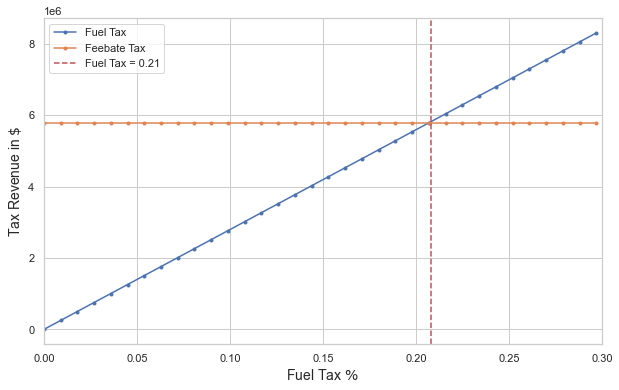

In [42]:
# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(results_df['tax'], results_df['Fuel_tax_taxrevenue_total'], label='Fuel Tax', marker='.')
plt.plot(results_df['tax'], results_df['feebate_taxrevenue'], label='Feebate Tax', marker='.')

# Adding a red dashed line at fuel tax = 0.21
plt.axvline(x=0.208, color='r', linestyle='--', label='Fuel Tax = 0.21')


plt.xlabel('Fuel Tax $\%$', fontsize=14)
plt.ylabel('Tax Revenue in $\$$', fontsize=14)
#plt.title('Tax Revenue Comparison', fontsize=16, weight='bold')
plt.legend()
plt.xlim(0, 0.3)
plt.grid(True)
#plt.show()




output_filepath = '/Users/mertcandogusoy/Desktop/Bachelorprojekt/Bachelorprojektet/Plots/fueltaxrevenuedecision.png'
plt.savefig(output_filepath, format='png')

#Close the plot
plt.close()

# Provide the path to the saved plot
output_filepath

**Conclusion: The fuel tax is 21% since**

## Counterfactual simulation

In [43]:
cars_est['Intercept'] = 1
cars_est_sim_FuelTax = cars_est.copy()
cars_est_sim_FuelTax = pd.get_dummies(cars_est_sim_FuelTax,columns=['cla_category'],drop_first=True)
cars_est_sim_FuelTax = pd.get_dummies(cars_est_sim_FuelTax,columns=['home_category'],drop_first=True)

# Fuel tax 10%
#tax = grouped_fuelTaxFromFeeBate['percentage_change'].reset_index()


In [44]:
#merged = pd.merge(cars_est_sim_FuelTax, tax, on='ye', how='left')

# Beregner den skattede brændstofpris
#cars_est_sim_FuelTax['Fuel_price_ann_dollar_taxed'] = (merged['Fuel_price_1L'] * (1 + merged['percentage_change'] / 100)) * merged['ann_km'] * (merged['li'] / 100)
#cars_est_sim_FuelTax

In [45]:
tax = 0.21
cars_est_sim_FuelTax['Fuel_price_ann_dollar_taxed'] = (cars_est_sim_FuelTax['Fuel_price_1L']*(1+tax)*cars_est_sim_FuelTax['ann_km']*(cars_est_sim_FuelTax['li']/100))*12
cars_est_sim_FuelTax

,ye,ma,co,zcode,brd,type,brand,model,org,loc,...,s_total_country_cla,s_total_cla,log_s,Intercept,cla_category_intermediate,cla_category_luxury,cla_category_standard,cla_category_subcompact,home_category_1,Fuel_price_ann_dollar_taxed
0,83,1,1,5,1,alfa 33,alfa romeo,33,3,5,...,0.00,0.00,-5.35,1,0,0,0,0,0,4912.35
1,84,1,1,5,1,alfa 33,alfa romeo,33,3,5,...,0.00,0.00,-4.50,1,0,0,0,0,0,4854.21
2,85,1,1,5,1,alfa 33,alfa romeo,33,3,5,...,0.00,0.00,-4.57,1,0,0,0,0,0,4518.47
3,86,1,1,5,1,alfa 33,alfa romeo,33,3,5,...,0.00,0.00,-4.46,1,0,0,0,0,0,2346.45
4,87,1,1,5,1,alfa 33,alfa romeo,33,3,5,...,0.00,0.00,-4.48,1,0,0,0,0,0,2950.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11544,99,5,955,291,31,volvo S80,volvo,S80,6,1,...,0.00,0.00,-5.51,1,0,1,0,0,0,3231.67
11545,99,5,977,229,23,rover 75,rover,75,7,12,...,0.00,0.00,-4.75,1,0,0,1,0,1,3469.67
11546,99,5,978,287,29,toyota yaris,toyota,yaris,4,6,...,0.00,0.00,-3.99,1,0,0,0,1,0,2630.43
11547,99,5,979,306,30,volkswagen lupo,VW,lupo,2,4,...,0.00,0.00,-5.30,1,0,0,0,1,0,2505.17


**Market share**

In [49]:
# calculate the: exp_beta_x=beta*x_{ni}
cars_est_sim_results['beta_x_FuelTax'] = np.dot(cars_est_sim_FuelTax, ols_model.params)

# Used to find max v for K
K_i_FuelTax = cars_est_sim_results['beta_x_FuelTax'].max() 
#K_i_FuelTax = 0

ValueError: shapes (11549,83) and (10,) not aligned: 83 (dim 1) != 10 (dim 0)

# 